In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os

In [23]:
df = pd.read_csv('toxicity_parsed_dataset.csv', index_col='index')
df = df.drop((df.loc[((df['ed_label_0']<0.9) & (df['oh_label'] != 1))]).index)
df

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,Elected or Electoral? JHK,1.0,0.0,0
3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
5,`:In an interpreted language your source code ...,0.9,0.1,0
...,...,...,...,...
159680,` == File:Romantic Warriors cover.jpg == You...,1.0,0.0,0
159681,` These sources don't exactly exude a sense ...,1.0,0.0,0
159682,The Institute for Historical Review is a pee...,1.0,0.0,0


In [50]:
n_samples = 5000
df_small = pd.concat([df[df['oh_label']==0].sample(n_samples), df[df['oh_label']==1].sample(n_samples)])
df_small

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
65981,"` :To question 1, of course -) It's the encycl...",1.0,0.0,0
67465,:::::::WP:POINT has nothing to do with that c...,1.0,0.0,0
124107,: Also note that recent pictures of Zimmerma...,0.9,0.1,0
129251,"` :::::::::: To which I pointed out, inter ali...",0.9,0.1,0
96838,"`::::::::As many illustrious folks once said, ...",1.0,0.0,0
...,...,...,...,...
78165,"== Bite Me, Redux == Really. Stop leaving ...",0.0,1.0,1
89863,`Do you see the paragraph that starts with How...,0.3,0.7,1
74439,Go fuk your mom you fukin faggot. I'll commit...,0.0,1.0,1


In [51]:
df_small.isna().sum()

Text          0
ed_label_0    0
ed_label_1    0
oh_label      0
dtype: int64

In [52]:
df_small['oh_label'].value_counts(normalize=True)

0    0.5
1    0.5
Name: oh_label, dtype: float64

In [53]:
sample = ' '.join(df['Text'][:10])
def treat(sample: str):
    sample = re.sub('\{.*\}','',sample)
    # sample = re.sub('\=.*\=','',sample)
    sample = re.sub('`','',sample)
    sample = re.sub(r'[^\w\s]','',sample)
    return sample.lower()

df_small['treated_text'] = df_small['Text'].apply(treat)
df_small

,Text,ed_label_0,ed_label_1,oh_label,treated_text
index,,,,,
65981,"` :To question 1, of course -) It's the encycl...",1.0,0.0,0,to question 1 of course its the encyclopedia...
67465,:::::::WP:POINT has nothing to do with that c...,1.0,0.0,0,wppoint has nothing to do with that comment
124107,: Also note that recent pictures of Zimmerma...,0.9,0.1,0,also note that recent pictures of zimmerman...
129251,"` :::::::::: To which I pointed out, inter ali...",0.9,0.1,0,to which i pointed out inter alia that calli...
96838,"`::::::::As many illustrious folks once said, ...",1.0,0.0,0,as many illustrious folks once said an apology...
...,...,...,...,...,...
78165,"== Bite Me, Redux == Really. Stop leaving ...",0.0,1.0,1,bite me redux really stop leaving silly ...
89863,`Do you see the paragraph that starts with How...,0.3,0.7,1,do you see the paragraph that starts with how ...
74439,Go fuk your mom you fukin faggot. I'll commit...,0.0,1.0,1,go fuk your mom you fukin faggot ill commit v...


In [54]:
reviews = list(df_small['treated_text'])
y = np.array(df_small[['oh_label']])
print(f'reviews.shape={len(reviews)}, {y.shape=}')

reviews.shape=10000, y.shape=(10000, 1)


In [55]:
vectorizer = CountVectorizer(binary=True, max_features=2000, stop_words=stopwords)
X = vectorizer.fit_transform(reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37)

/home/user/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


In [56]:
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1272
           1       0.71      0.91      0.80      1228

    accuracy                           0.78      2500
   macro avg       0.80      0.78      0.77      2500
weighted avg       0.80      0.78      0.77      2500



/home/user/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


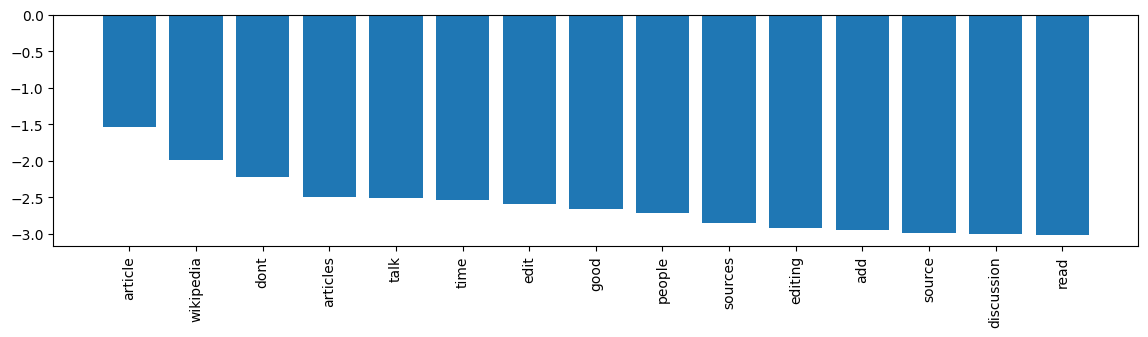

In [65]:
vocab = vectorizer.vocabulary_
# Probabilidades
palavras_ham = []
palavras_spam = []
for t in vocab.keys():
    prob_ham = model.feature_log_prob_[0, vocab[t]]
    palavras_ham.append( (prob_ham, t) )
    prob_spam = model.feature_log_prob_[1, vocab[t]]
    palavras_spam.append( (prob_spam, t) )
    
tuplas_ordenadas = sorted(palavras_ham, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
plt.show()

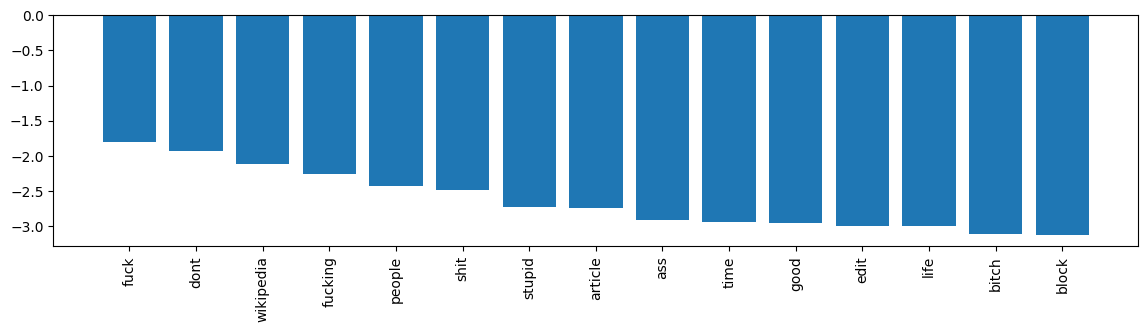

In [66]:
# Mostrando num gráfico
tuplas_ordenadas = sorted(palavras_spam, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 15
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
plt.show()

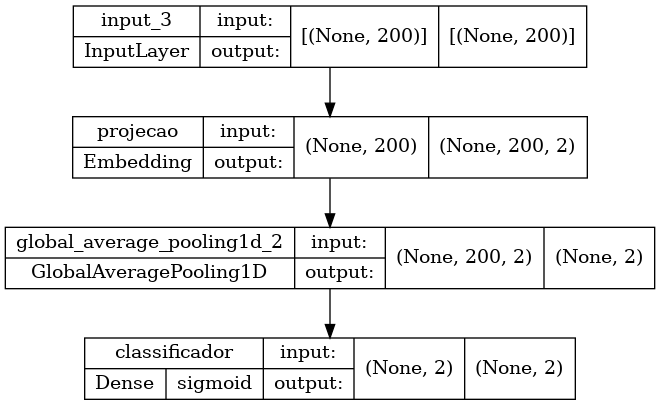

In [57]:
def rede_neural_classificar_por_palavra(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_classificar_por_palavra(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [58]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [59]:
padded = pad_sequences(sequences,maxlen=200)
X_train, X_test, y_train, y_test = train_test_split(padded, y, random_state=37)
padded

array([[  0,   0,   0, ..., 113,  19, 269],
       [  0,   0,   0, ...,  22,   9, 232],
       [  0,   0,   0, ...,  25, 303,  56],
       ...,
       [  0,   0,   0, ..., 290, 451, 191],
       [  0,   0,   0, ..., 108, 122, 564],
       [  0,   0,   0, ...,   1, 270, 108]], dtype=int32)

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 0.2488 - val_loss: 0.2473
Epoch 2/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2458 - val_loss: 0.2436
Epoch 3/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2419 - val_loss: 0.2394
Epoch 4/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2374 - val_loss: 0.2356
Epoch 5/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2329 - val_loss: 0.2309
Epoch 6/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2285 - val_loss: 0.2267
Epoch 7/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2241 - val_loss: 0.2228
Epoch 8/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2197 - val_loss: 0.2186
Epoch 9/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2152 - val_loss: 0.2155
Epoch 10/500
188/188 [==============================] - 1s 3ms/step - loss: 0.2110 - val_lo

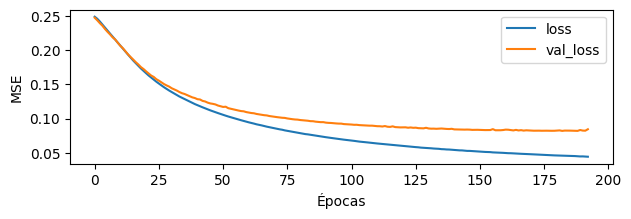

In [61]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [64]:
def unencode(tup: tuple):
    if tup[0] < tup[1]:
        return 0
    return 1

y_est = rede_neural.predict(X_test)
print(classification_report(y_test, list(map(unencode,y_est))))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1272
           1       0.87      0.86      0.87      1228

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



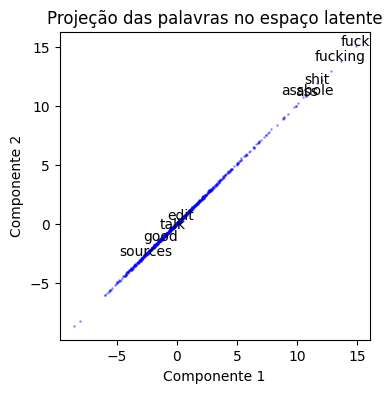

In [68]:
w = rede_neural.get_layer('projecao').get_weights()
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in "fuck fucking shit ass asshole sources good edit talk".split():
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

In [92]:
def predict_label(phrase: str):
    test = pad_sequences(tokenizer.texts_to_sequences([phrase]),maxlen=200)
    pred = rede_neural.predict(test)
    x_nb = vectorizer.transform([phrases[0]]).toarray()
    nb = model.predict(x_nb)[0]
    return f'"{phrase}" \n\tNN: \n\tlabel: {unencode(list(pred[0]))} {list(pred[0])} \n\tNB: \n\tlabel: {nb}'

phrases = [
    "hello there may i interest you in general kenobi",
    "fuck i fucking hate you die die die",
    "this is great content",
    "i fucking love this",
]

[print(x) for x in list(map(predict_label, phrases))];

"hello there may i interest you in general kenobi" 
	NN: 
	label: 0 [0.09233846, 0.09329468] 
	NB: 
	label: 1
"fuck i fucking hate you die die die" 
	NN: 
	label: 1 [0.9999999, 0.9999999] 
	NB: 
	label: 1
"this is great content" 
	NN: 
	label: 0 [0.20372428, 0.20471631] 
	NB: 
	label: 1
"i fucking love this" 
	NN: 
	label: 1 [0.9773318, 0.9768808] 
	NB: 
	label: 1


1